In [1]:
import torch # Check if CUDA is available
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import numpy as np
import seaborn as sns
import time



if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("GPU not available, using CPU instead.")

Using GPU: Tesla P100-PCIE-16GB


In [2]:
!cp -r /kaggle/input/stanford-car-dataset-by-classes-folder/car_data/ .

In [ ]:
import os
import shutil

def reorganize_dataset(source_dir, target_dir):
    """
    Reorganize the dataset by car brand.

    Parameters:
    source_dir (str): The directory where the current dataset is stored.
    target_dir (str): The directory where the reorganized dataset will be stored.
    """
    # Create the target directory if it doesn't exist
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)

    # List all files in the source directory
    directories = [d for d in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, d))]

    # Process each file
    for directory in directories:
        # Extract brand name (assuming it's the first word of the file name)
        brand = directory.split(' ')[0]

        # Create a directory for the brand if it doesn't exist
        brand_dir = os.path.join(target_dir, brand)
        if not os.path.exists(brand_dir):
            os.makedirs(brand_dir)
            
        current_dir_path = os.path.join(source_dir, directory)
        # Move each file in the current directory to the brand directory
        for file in os.listdir(current_dir_path):
            src_path = os.path.join(current_dir_path, file)
            dst_path = os.path.join(brand_dir, file)
            shutil.move(src_path, dst_path)
            print(f"Moved {file} from {current_dir_path} to {brand_dir}")
        
        
source_train = 'car_data/car_data/train'
source_test = 'car_data/car_data/test'
reorganize_dataset(source_train, 'train')
reorganize_dataset(source_test, 'test')

In [4]:
BATCH_SIZE = 32

transform = transforms.Compose([
    transforms.Resize((400, 400)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_tfms = transforms.Compose([
    transforms.Resize((400, 400)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


train_set = datasets.ImageFolder('train', transform=transform)
test_set = datasets.ImageFolder('test', transform=test_tfms)

In [5]:
len(train_set.classes)

49

In [6]:
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [7]:
def train_model(model, criterion, optimizer, scheduler, n_epochs = 5):
    
    losses = []
    accuracies = []
    test_accuracies = []
    # set the model to train mode initially
    model.train()
    model=model.to('cuda')
    for epoch in range(n_epochs):
        since = time.time()
        running_loss = 0.0
        running_correct = 0.0
        for i, data in enumerate(train_loader, 0):

            # get the inputs and assign them to cuda
            inputs, labels = data
            
            inputs, labels = inputs.cuda(), labels.cuda()
            optimizer.zero_grad()
             # forward + backward + optimize
                
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # calculate the loss/acc later
            running_loss += loss.item()
            running_correct += (labels==predicted).sum().item()

        epoch_duration = time.time()-since
        epoch_loss = running_loss/len(train_loader)
        epoch_acc = 100/BATCH_SIZE*running_correct/len(train_loader)
        print("Epoch %s, duration: %d s, loss: %.4f, acc: %.4f" % (epoch+1, epoch_duration, epoch_loss, epoch_acc))
        
        losses.append(epoch_loss)
        accuracies.append(epoch_acc)
        model.eval()
        test_acc = eval_model(model)
        test_accuracies.append(test_acc)
        
        # re-set the model to train mode after validating
        model.train()
        scheduler.step(test_acc)
        since = time.time()
    print('Finished Training')
    return model, losses, accuracies, test_accuracies


def eval_model(model):
    correct = 0.0
    total = 0.0
    with torch.no_grad():
        for i, data in enumerate(test_loader, 0):
            images, labels = data
            
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        test_acc = 100.0 * correct / total
    print('Accuracy of the network on the test images: %d %%' % (
        test_acc))
    return test_acc

In [8]:
import torchvision.models as models

model = models.resnet18(pretrained=True)

num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 49)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 119MB/s] 


In [9]:
model, training_losses, training_accs, test_accs = train_model(model, criterion, optimizer, lrscheduler, n_epochs=10)

Epoch 1, duration: 58 s, loss: 2.3480, acc: 38.8971
Accuracy of the network on the test images: 59 %
Epoch 2, duration: 57 s, loss: 1.0537, acc: 70.3309
Accuracy of the network on the test images: 64 %
Epoch 3, duration: 57 s, loss: 0.6012, acc: 82.7574
Accuracy of the network on the test images: 68 %
Epoch 4, duration: 58 s, loss: 0.3748, acc: 89.2279
Accuracy of the network on the test images: 78 %
Epoch 5, duration: 57 s, loss: 0.2533, acc: 92.4632
Accuracy of the network on the test images: 84 %
Epoch 6, duration: 57 s, loss: 0.1018, acc: 97.4877
Accuracy of the network on the test images: 91 %
Epoch 7, duration: 57 s, loss: 0.0637, acc: 98.5539
Accuracy of the network on the test images: 91 %
Epoch 8, duration: 57 s, loss: 0.0487, acc: 98.9951
Accuracy of the network on the test images: 92 %
Epoch 9, duration: 57 s, loss: 0.0378, acc: 99.3995
Accuracy of the network on the test images: 92 %
Epoch 10, duration: 58 s, loss: 0.0342, acc: 99.5098
Accuracy of the network on the test im

In [10]:
torch.save(model, 'brand_model.pth')

In [11]:
!cp -r /kaggle/input/stanford-car-dataset-by-classes-folder/car_data/ .

In [ ]:
def reorganize_dataset_chevrolet(source_dir, target_dir):
    """
    Reorganize the dataset by car brand.

    Parameters:
    source_dir (str): The directory where the current dataset is stored.
    target_dir (str): The directory where the reorganized dataset will be stored.
    """
    # Create the target directory if it doesn't exist
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)

    # List all files in the source directory
    directories = [d for d in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, d))]

    # Process each file
    for directory in directories:
        # Extract brand name (assuming it's the first word of the file name)
        brand = directory.split(' ')[0]
        if brand == 'Chevrolet':
        # Create a directory for the brand if it doesn't exist
            brand_dir = os.path.join(target_dir, directory)
            if not os.path.exists(brand_dir):
                os.makedirs(brand_dir)
            
            current_dir_path = os.path.join(source_dir, directory)
            print(directory)
            # Move each file in the current directory to the brand directory
            for file in os.listdir(current_dir_path):
                src_path = os.path.join(current_dir_path, file)
                dst_path = os.path.join(brand_dir, file)
                shutil.move(src_path, dst_path)
                print(f"Moved {file} from {current_dir_path} to {brand_dir}")

        
source_train = 'car_data/car_data/train'
source_test = 'car_data/car_data/test'
reorganize_dataset_chevrolet(source_train, 'train_chevrolet')
reorganize_dataset_chevrolet(source_test, 'test_chevrolet')

In [13]:
train_chevrolet_set = datasets.ImageFolder('train_chevrolet', transform=transform)
test_chevrolet_set = datasets.ImageFolder('test_chevrolet', transform=test_tfms)

In [14]:
len(train_chevrolet_set.classes)

22

In [15]:
train_loader = DataLoader(train_chevrolet_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
test_loader = DataLoader(test_chevrolet_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [16]:
model_chevrolet = models.resnet18(pretrained=True)

num_ftrs = model_chevrolet.fc.in_features
model_chevrolet.fc = torch.nn.Linear(num_ftrs, 22)
model_chevrolet.to(device)
criterion_2 = nn.CrossEntropyLoss()
optimizer_2 = optim.SGD(model_chevrolet.parameters(), lr=0.01, momentum=0.9)
lrscheduler_2 = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)

In [17]:
model_chevrolet, training_losses_chevrolet, training_accs_chevrolet, test_accs_chevrolet = train_model(model_chevrolet, criterion_2, optimizer_2, lrscheduler_2, n_epochs=20)

Epoch 1, duration: 7 s, loss: 2.9414, acc: 12.7155
Accuracy of the network on the test images: 22 %
Epoch 2, duration: 7 s, loss: 1.4554, acc: 51.4009
Accuracy of the network on the test images: 42 %
Epoch 3, duration: 7 s, loss: 0.7605, acc: 74.3534
Accuracy of the network on the test images: 66 %
Epoch 4, duration: 7 s, loss: 0.4161, acc: 85.3448
Accuracy of the network on the test images: 70 %
Epoch 5, duration: 7 s, loss: 0.2989, acc: 89.2241
Accuracy of the network on the test images: 69 %
Epoch 6, duration: 7 s, loss: 0.2096, acc: 92.3491
Accuracy of the network on the test images: 75 %
Epoch 7, duration: 7 s, loss: 0.1619, acc: 93.5345
Accuracy of the network on the test images: 77 %
Epoch 8, duration: 7 s, loss: 0.1106, acc: 95.0431
Accuracy of the network on the test images: 76 %
Epoch 9, duration: 7 s, loss: 0.1126, acc: 93.7500
Accuracy of the network on the test images: 72 %
Epoch 10, duration: 7 s, loss: 0.0781, acc: 95.9052
Accuracy of the network on the test images: 77 %

In [18]:
torch.save(model_chevrolet, 'chevrolet_model.pth')

In [19]:
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [20]:
model.eval()  # Set the model to evaluation mode

misclassified_examples = []

with torch.no_grad():  # No need to track gradients
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        
        misclassifications = predictions != labels
        for image, label, prediction in zip(images[misclassifications], labels[misclassifications], predictions[misclassifications]):
            misclassified_examples.append((image.cpu(), label.cpu(), prediction.cpu()))

In [22]:
test_set.classes.index('Chevrolet')

9

In [25]:
import pandas as pd

misclassified_df = [{'Label': label.item(), 'Prediction': prediction.item()} for _, label, prediction in misclassified_examples]
misclassified_df = pd.DataFrame(misclassified_df)
misclassified_df['Label_name'] = misclassified_df['Label'].apply(lambda x : train_set.classes[x])
misclassified_df['Prediction_name'] = misclassified_df['Prediction'].apply(lambda x : train_set.classes[x])
misclassified_df

,Label,Prediction,Label_name,Prediction_name
0,0,20,AM,HUMMER
1,0,20,AM,HUMMER
2,0,20,AM,HUMMER
3,1,22,Acura,Hyundai
4,1,27,Acura,Lamborghini
...,...,...,...,...
598,48,14,smart,FIAT
599,48,30,smart,MINI
600,48,46,smart,Volkswagen
601,48,4,smart,BMW


In [33]:
misclassified_df[misclassified_df['Label'] == 9]

,Label,Prediction,Label_name,Prediction_name
0,0,20,AM,HUMMER
1,0,20,AM,HUMMER
2,0,20,AM,HUMMER


In [30]:
df_chevrolet_errors = misclassified_df[misclassified_df['Label'] == 9]

In [28]:
def display_class_distribution(data_loader):
    # Assuming the DataLoader is for a Subset of a ConcatDataset
    dataset = data_loader.dataset.dataset if isinstance(data_loader.dataset, Subset) else data_loader.dataset
    is_concat = isinstance(dataset, torch.utils.data.ConcatDataset)

    # Initialize class count dictionary
    if is_concat:
        # Assuming all sub-datasets have the same classes attribute, accessed from the first dataset
        all_classes = dataset.datasets[0].classes
    else:
        all_classes = dataset.classes

    class_counts = {class_name: 0 for class_name in all_classes}

    # Calculate class counts
    for _, labels in data_loader:
        for label in labels:
            class_name = all_classes[label.item()]
            class_counts[class_name] += 1

    # Plotting
    plt.figure(figsize=(30, 10))
    sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
    plt.xticks(rotation=90)
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.title('Distribution of Classes in Dataset')
    plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


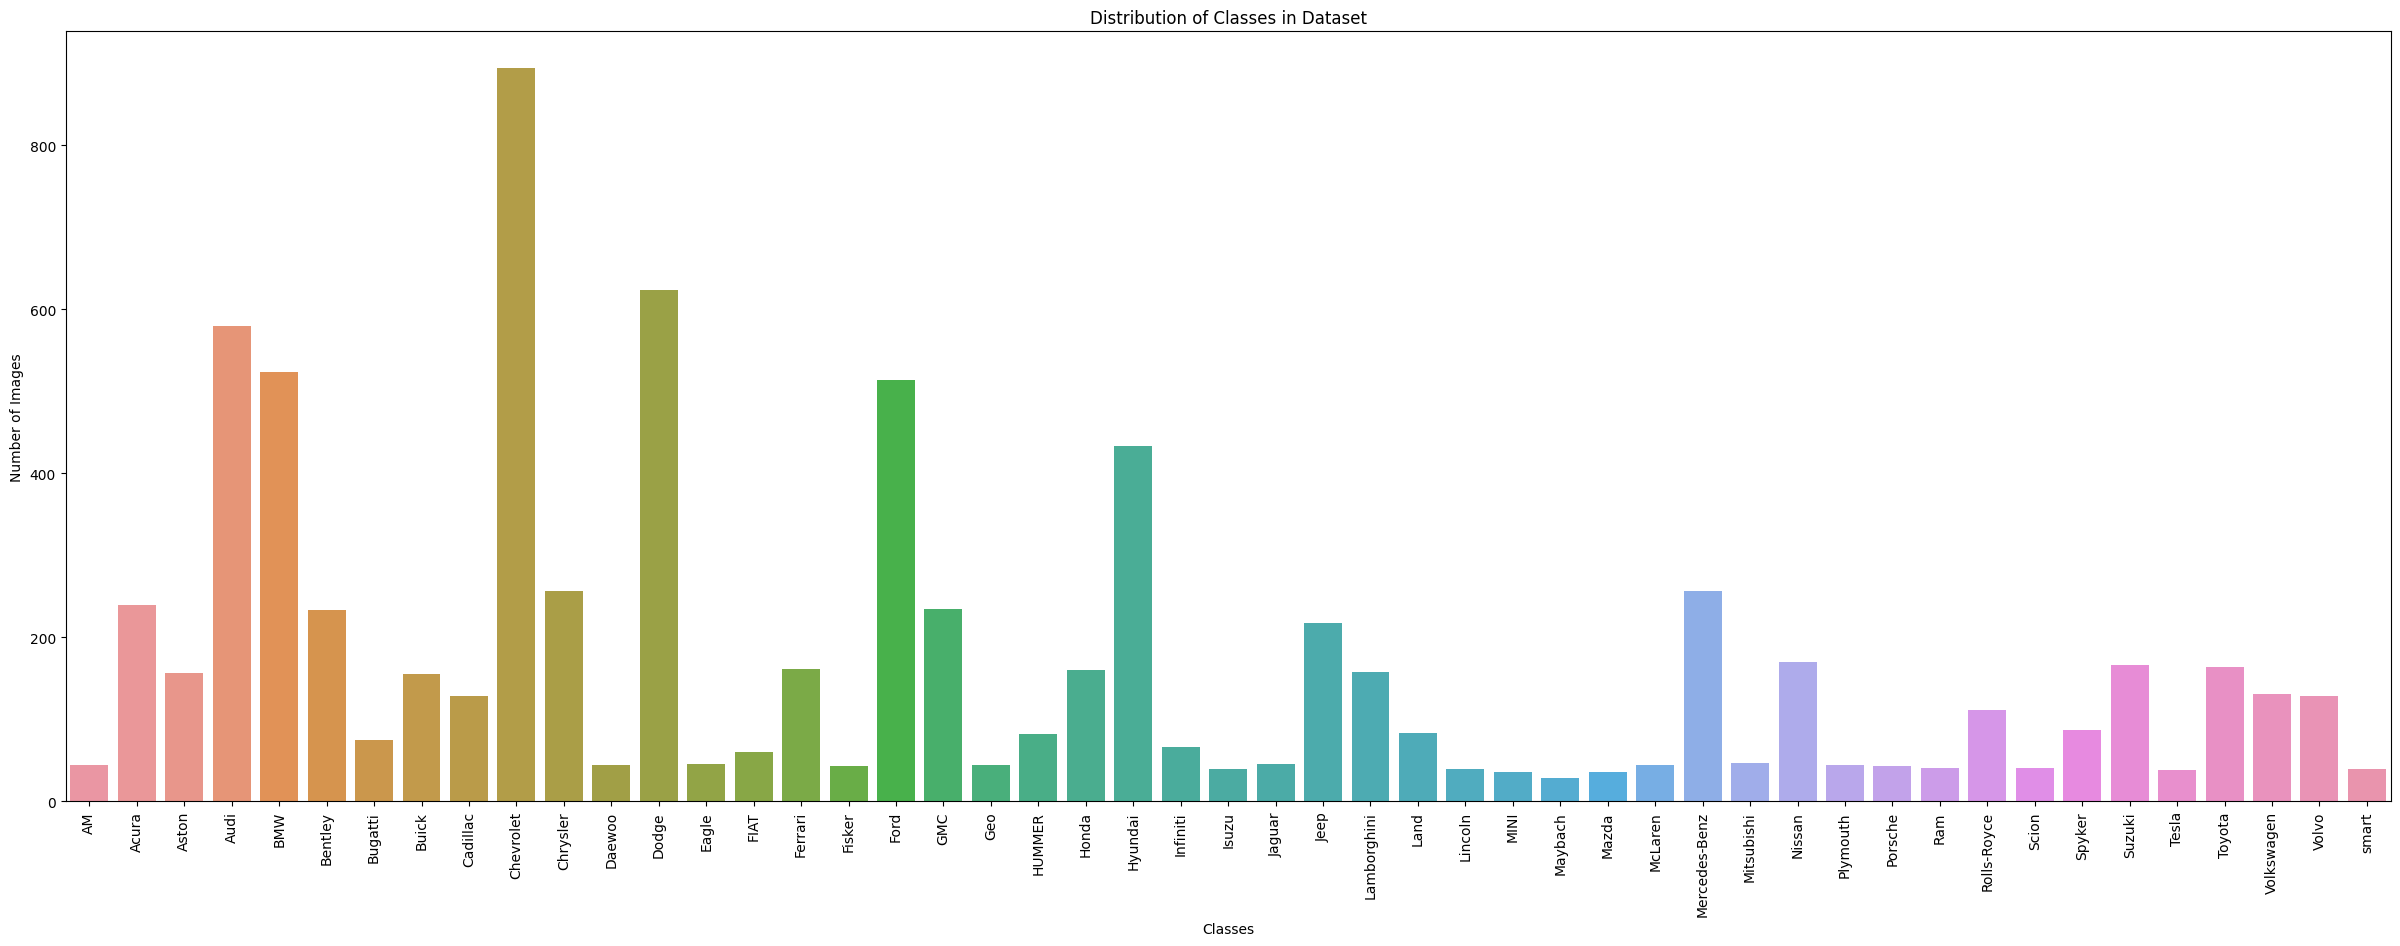

In [29]:
display_class_distribution(test_loader)

In [32]:
chevrolet_samples_count = 0

for _, labels in test_loader:
    for label in labels:
        if label == 9:
            chevrolet_samples_count += 1
            
            
test_acc = 100.0 * (chevrolet_samples_count - len(df_chevrolet_errors)) / chevrolet_samples_count
print('Accuracy of the network on detecting Chevrolet cars: %d %%' % (
        test_acc))

Accuracy of the network on detecting Chevrolet cars: 92 %


In [34]:
train_loader = DataLoader(train_chevrolet_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
test_loader = DataLoader(test_chevrolet_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [35]:
model_chevrolet.eval()  # Set the model to evaluation mode

misclassified_chevrolet = []

with torch.no_grad():  # No need to track gradients
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_chevrolet(images)
        _, predictions = torch.max(outputs, 1)
        
        misclassifications = predictions != labels
        for image, label, prediction in zip(images[misclassifications], labels[misclassifications], predictions[misclassifications]):
            misclassified_chevrolet.append((image.cpu(), label.cpu(), prediction.cpu()))

In [43]:
len(test_chevrolet_set)

894

In [44]:
misclassified_chevrolet_df = [{'Label': label.item(), 'Prediction': prediction.item()} for _, label, prediction in misclassified_chevrolet]
misclassified_chevrolet_df = pd.DataFrame(misclassified_chevrolet_df)
misclassified_chevrolet_df['Label_name'] = misclassified_chevrolet_df['Label'].apply(lambda x : test_chevrolet_set.classes[x])
misclassified_chevrolet_df['Prediction_name'] = misclassified_chevrolet_df['Prediction'].apply(lambda x : test_chevrolet_set.classes[x])
misclassified_chevrolet_df[:50]

,Label,Prediction,Label_name,Prediction_name
0,0,19,Chevrolet Avalanche Crew Cab 2012,Chevrolet Tahoe Hybrid SUV 2012
1,0,19,Chevrolet Avalanche Crew Cab 2012,Chevrolet Tahoe Hybrid SUV 2012
2,0,19,Chevrolet Avalanche Crew Cab 2012,Chevrolet Tahoe Hybrid SUV 2012
3,0,19,Chevrolet Avalanche Crew Cab 2012,Chevrolet Tahoe Hybrid SUV 2012
4,0,19,Chevrolet Avalanche Crew Cab 2012,Chevrolet Tahoe Hybrid SUV 2012
5,0,19,Chevrolet Avalanche Crew Cab 2012,Chevrolet Tahoe Hybrid SUV 2012
6,0,10,Chevrolet Avalanche Crew Cab 2012,Chevrolet Malibu Hybrid Sedan 2010
7,0,19,Chevrolet Avalanche Crew Cab 2012,Chevrolet Tahoe Hybrid SUV 2012
8,0,19,Chevrolet Avalanche Crew Cab 2012,Chevrolet Tahoe Hybrid SUV 2012
9,0,21,Chevrolet Avalanche Crew Cab 2012,Chevrolet Traverse SUV 2012
